In [30]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, RocCurveDisplay
from libcharlotte import process_data, transform_labels, get_start_dates
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from quantstats.reports import full
from tqdm.auto import tqdm

In [31]:
# read in dataframe
df = pd.read_csv("merged_data.csv", index_col='Date', parse_dates=['Date'])
new_idx = pd.date_range(min(df.index), max(df.index), freq='D')
df = df.reindex(new_idx)

cols = list(df.columns)
cols.remove("crude_net")
cols.remove("products_net")
cols.remove("gas_supplied")

_, _, df_proc = process_data(df, cols, 20, [20*i for i in range(7)], "1990-01-01", "2021-12-31")

## Create XGBoost Model

In [66]:
model = XGBRegressor(objective = 'binary:logistic')

days_forecast = 20
X = df_proc[:-days_forecast]

crack_reindex = df.crack.reindex_like(df_proc)
crack_targets = (crack_reindex.shift(-days_forecast)/crack_reindex - 1)[:-days_forecast]
crack_targets = crack_targets.fillna(method = 'ffill')
crack_targets = crack_targets.reindex_like(X)

_, y = transform_labels(crack_targets, 75)

cutoff_date = datetime(2012, 1, 1).date()

X_train = X[X.index <= cutoff_date]
X_test = X[X.index > cutoff_date]

y_train = y[y.index <= cutoff_date]
y_test = y[y.index > cutoff_date]

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='binary:logistic', predictor='auto',
             random_state=0, reg_alpha=0, ...)

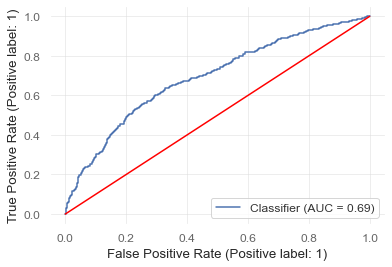

In [67]:
s = np.linspace(0, 1, 100)
y_hat = model.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_curve_plot = RocCurveDisplay.from_predictions(y_test, y_hat)
plt.plot(s, s, color = 'red')
plt.show()

In [68]:
plt.plot(threshold, tpr)
plt.axvline(x = 0.1, color = 'red')
plt.show()

## Trading Model

In [69]:
plt.hist(y_hat, bins='scott', density=True)
plt.show()

In [70]:
target_threshold = 0.1

trade_decisions = pd.Series(y_hat, name="position")
trade_decisions.index = X_test.index
trade_decisions = trade_decisions.apply(lambda x: int(x >= target_threshold))

trade_decisions.head()

2012-01-03    1
2012-01-04    1
2012-01-05    1
2012-01-06    1
2012-01-09    0
Name: position, dtype: int64

In [71]:
trade_decisions.describe()

count    2497.000000
mean        0.313176
std         0.463878
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: position, dtype: float64

In [72]:
crack_returns = df.crack.reindex_like(trade_decisions)
crack_returns = (crack_returns.shift(-1)/crack_returns - 1).dropna()
crack_returns

2012-01-03    0.044530
2012-01-04   -0.076080
2012-01-05    0.118249
2012-01-06   -0.002919
2012-01-09   -0.000399
                ...   
2021-11-22    0.092235
2021-11-23   -0.052800
2021-11-29   -0.027783
2021-11-30   -0.042656
2021-12-01    0.116111
Name: crack, Length: 2476, dtype: float64

In [73]:
trade_decisions2 = trade_decisions.reindex_like(crack_returns)
trade_returns = trade_decisions2*crack_returns
trade_returns.index = pd.DatetimeIndex(trade_returns.index)

In [74]:
trade_returns.head()

2012-01-03    0.044530
2012-01-04   -0.076080
2012-01-05    0.118249
2012-01-06   -0.002919
2012-01-09   -0.000000
dtype: float64

In [75]:
trade_returns.describe()

count    2476.000000
mean        0.012437
std         0.567417
min        -5.345154
25%        -0.000000
50%         0.000000
75%         0.000000
max        27.307692
dtype: float64

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-01-03  2012-01-03
End Period                 2021-12-01  2021-12-01
Risk-Free Rate             0.0%        0.0%
Time in Market             32.0%       100.0%

Cumulative Return          231.98%     326.42%
CAGR﹪                     12.86%      15.75%

Sharpe                     0.35        1.0
Prob. Sharpe Ratio         98.01%      99.88%
Smart Sharpe               0.34        0.99
Sortino                    1.57        1.4
Smart Sortino              1.55        1.38
Sortino/√2                 1.11        0.99
Smart Sortino/√2           1.1         0.98
Omega                      1.96        1.96

Max Drawdown               -85.11%     -33.72%
Longest DD Days            621         272
Volatility (ann.)          126.1%      16.02%
R^2                        0.04        0.04
Information Ratio          0.01        0.01
Calmar                     0.15        

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-03-20  2020-04-01  2021-12-01   621    -85.105404        -81.614232
2  2019-12-26  2020-03-13  2020-03-16    81    -19.546220         -9.334751
3  2018-10-19  2019-01-28  2019-02-14   118    -11.126048        -10.128026
4  2016-12-30  2017-02-28  2017-03-17    77    -10.189080         -9.688327
5  2020-03-18  2020-03-18  2020-03-19     1     -8.245713          0.000000

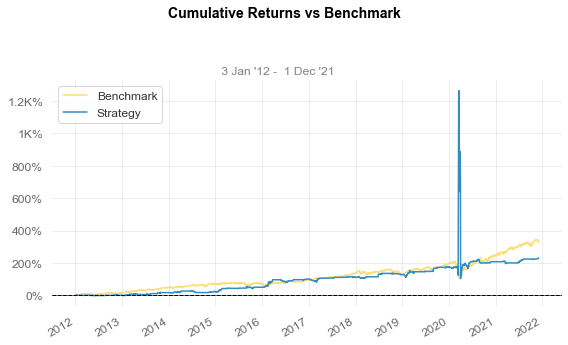

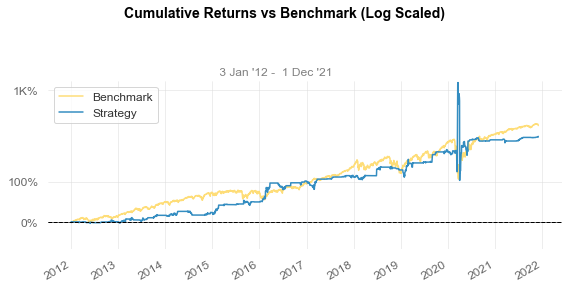

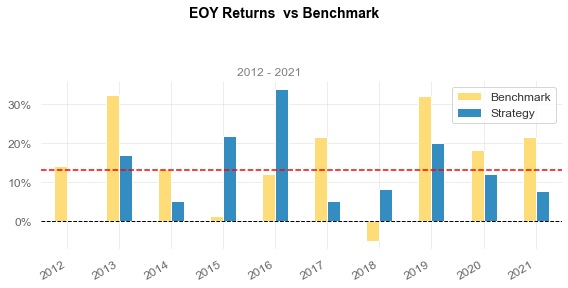

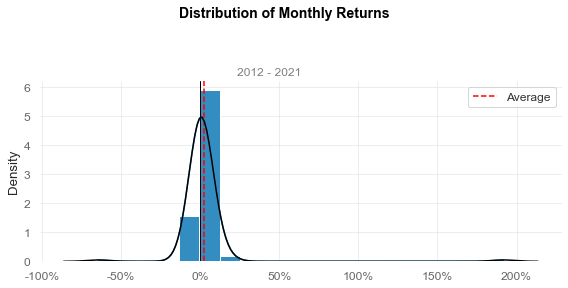

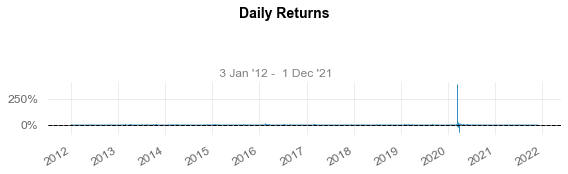

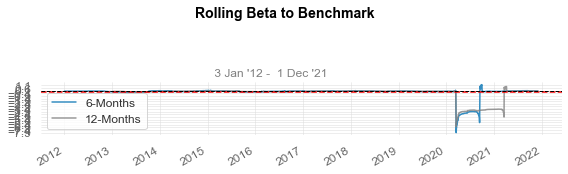

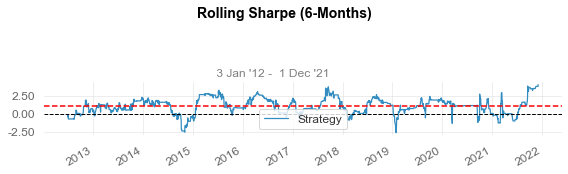

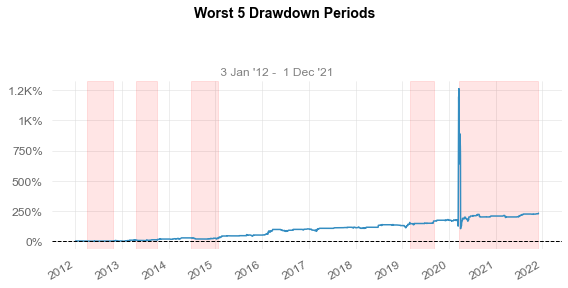

In [76]:
full(trade_returns*0.14, 'SPY')